# Getting acquainted with CIFAR10

- Loading CIFAR10
- Trying to train it using the PseudoMLP architecture

In [12]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import Callable
import flax
from flax import nnx
from functools import partial
import math
import tensorflow as tf
import tensorflow_datasets as tfds
import optax

import matplotlib.pyplot as plt
import seaborn as sns

from models import MLPLayer
from utils import clipping_ste

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the CIFAR-10 Dataset

In [46]:
DATA_PATH = "/local_disk/vikrant/datasets"

def load_cifar10(batch_size: int, train_steps: int, binarize: bool = True, greyscale: bool = True, data_dir: str = DATA_PATH, seed: int = 0, threshold: float = 0.5, shuffle_buffer: int = 1024):
    """
    Load CIFAR-10 dataset
    """

    tf.random.set_seed(seed)

    train_ds, test_ds = tfds.load('cifar10', split=['train', 'test'], data_dir=data_dir)

    # normalize
    def _normalize(sample):
        img = tf.cast(sample['image'], tf.float32) / 255.0

        if greyscale:
            img = tf.reduce_mean(img, axis=-1, keepdims=True)
        
        return {'image': img, 'label': sample['label']}

    train_ds = train_ds.map(_normalize)
    test_ds = test_ds.map(_normalize)

    # binarize
    if binarize:
        binarize_mask = lambda s: {
            'image': tf.where(s['image'] > threshold, 1.0, 0.0),
            'label': s['label']
        }

        train_ds = train_ds.map(binarize_mask)
        test_ds = test_ds.map(binarize_mask)

    # shuffle the dataset
    train_ds = train_ds.repeat().shuffle(shuffle_buffer)
    train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
    test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

    return train_ds, test_ds


# testing
batch_size = 128
train_steps = 5000
eval_every = 50
train_ds, test_ds = load_cifar10(batch_size = batch_size, train_steps = train_steps, binarize=False)


In [48]:
batch = next(iter(train_ds))
batch['image'].shape

2025-04-22 16:15:15.505551: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


TensorShape([128, 32, 32, 1])

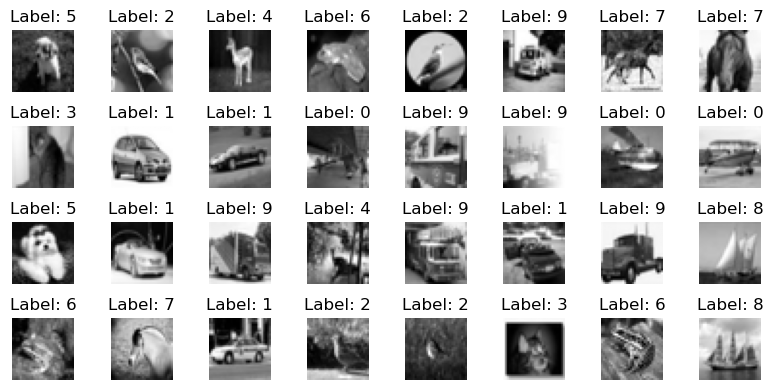

In [49]:
def plot_batch(batch, nrows=4, ncols=8):
    images = batch['image'].numpy()
    labels = batch['label'].numpy()

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
    
    for i, ax in enumerate(axs.flatten()):
        img = images[i]
        img = np.squeeze(img, axis=-1)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_batch(batch)



## Define Model

In [50]:
"""
Define a MLP-like architecture mappable to RRAM-cores
"""
class PseudoMLP(nnx.Module):
    """
    RRAM-mappable architecture with API of a standard MLP
    """

    @staticmethod
    def linear_map(
        x: jax.Array,
        threshold: float = None,
        noise_sd: float = None,
        key: jax.random.key = None
    ):
        return x

    def __init__(self, 
    layers: list, # list of layers
    rngs: nnx.Rngs, # nnx PRNG stream
    dense_activation_fn: Callable, # activation functions used by the RRAM cores
    accumulator_activation_fn: Callable, # activation functions used by the accumulator
    threshold = 0.0, # threshold for binary activation
    noise_sd = 0.05, # standard deviation for noise for binary activation
    ):

        self.layers = layers
        self.rngs = rngs
        self.dense_activation_fn = dense_activation_fn
        self.accumulator_activation_fn = accumulator_activation_fn
        self.threshold = threshold
        self.noise_sd = noise_sd

        # initialize the layers 
        self.mlp_layers = [
            MLPLayer(
                in_size = li,
                out_size = lo,
                rngs = self.rngs,
                dense_activation_fn = self.dense_activation_fn,
                accumulator_activation_fn = self.accumulator_activation_fn,
                threshold = self.threshold,
                noise_sd = self.noise_sd
            ) for li, lo in zip(self.layers[:-1], self.layers[1:-1])
        ]

        # define the last layer
        self.output_layer = MLPLayer(
            in_size = self.layers[-2],
            out_size = self.layers[-1],
            rngs = self.rngs,
            dense_activation_fn = self.dense_activation_fn,
            accumulator_activation_fn = self.linear_map,
            threshold = self.threshold,
            noise_sd = self.noise_sd
        )

        self.mlp_layers.append(self.output_layer)

    def __call__(self, x:jax.Array) -> jax.Array:

        # making first layer 1024-wide to maximally utilize the cores
        # x = jax.image.resize(x, (x.shape[0], 32, 32, 1), method='nearest') 
        x = x.reshape(x.shape[0], -1)
        
        for layer in self.mlp_layers:
            x = layer(x)
            
        # use population coding to get the final output
        x = x[:, :250].reshape(x.shape[0], 10, 25)
        pop_logits = jnp.average(x, axis = -1)

        return pop_logits

    def get_num_cores(self):

            """
            Get the number of cores in the model.
            """
            blocks = [math.ceil(l/256) for l in self.layers]
            cores_per_layer = [b_in*b_out + b_out for b_in, b_out in zip(blocks[:-1], blocks[1:])]
            return sum(cores_per_layer)



In [62]:
layers = [1024, 4096, 4096, 512, 256] # 19 cores setup [1024, 512, 512, 256], 61 cores setup: [1024, 2048, 512, 256]
rngs = nnx.Rngs(params=134, activation=67565)
model = PseudoMLP(
    layers=layers,
    rngs=rngs,
    dense_activation_fn=clipping_ste,
    accumulator_activation_fn=clipping_ste,
    threshold=0.0,
    noise_sd=1e-1
)

print(f"No. of cores: {model.get_num_cores()}")
nnx.display(model)

No. of cores: 389


In [52]:
# test the model
batch = train_ds.as_numpy_iterator().__next__()
y = model(batch['image'])
print(f"Output shape: {y.shape}")
print(f"Subset of output: {y[0,...]}")

2025-04-22 16:15:24.379417: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Output shape: (128, 10)
Subset of output: [-0.21481246  0.2682208   0.09536441 -0.09829251 -0.11258648 -0.00771342
 -0.1576295  -0.0027371   0.1018092  -0.08046335]


In [63]:
def loss_fn(model: PseudoMLP, batch):
  logits = model(batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
  ).mean()
  return loss, logits

@nnx.jit
def train_step(model: PseudoMLP, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step(model: PseudoMLP, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.

In [64]:
learning_rate = 1e-3
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

In [65]:
metrics_history = {
'train_loss': [],
'train_accuracy': [],
'test_loss': [],
'test_accuracy': [],
}


for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - The train state's model parameters
  # - The optimizer state
  # - The training loss and accuracy batch metrics

  train_step(model, optimizer, metrics, batch)

  if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
    # Log the training metrics.
    for metric, value in metrics.compute().items():  # Compute the metrics.
      metrics_history[f'train_{metric}'].append(value)  # Record the metrics.
    metrics.reset()  # Reset the metrics for the test set.

    # Compute the metrics on the test set after each training epoch.
    for test_batch in test_ds.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    # Log the test metrics.
    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()  # Reset the metrics for the next training epoch.

    print("------------------------")
    print(f"Step {step}: Test loss: {metrics_history['test_loss'][-1]}, Accuracy: {metrics_history['test_accuracy'][-1]}")
    print(f"Step {step}: Train loss: {metrics_history['train_loss'][-1]}, Accuracy: {metrics_history['train_accuracy'][-1]}")
    print("------------------------")

best_accuracy = max(metrics_history['test_accuracy'])
print(f"Best accuracy: {best_accuracy}")

------------------------
Step 50: Test loss: 2.1784651279449463, Accuracy: 0.21524439752101898
Step 50: Train loss: 2.2234182357788086, Accuracy: 0.17570465803146362
------------------------
------------------------
Step 100: Test loss: 2.180321455001831, Accuracy: 0.20763221383094788
Step 100: Train loss: 2.190764904022217, Accuracy: 0.20703125
------------------------
------------------------
Step 150: Test loss: 2.1695473194122314, Accuracy: 0.20993590354919434
Step 150: Train loss: 2.169346332550049, Accuracy: 0.21484375
------------------------
------------------------
Step 200: Test loss: 2.1681976318359375, Accuracy: 0.21814903616905212
Step 200: Train loss: 2.1665496826171875, Accuracy: 0.21171873807907104
------------------------
------------------------
Step 250: Test loss: 2.166510820388794, Accuracy: 0.21003605425357819
Step 250: Train loss: 2.167630672454834, Accuracy: 0.21453124284744263
------------------------
------------------------
Step 300: Test loss: 2.154453277587

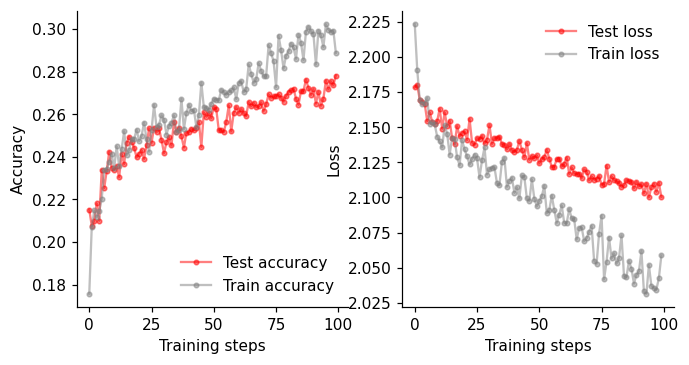

In [67]:
# plotting the metrics
test_acc = metrics_history['test_accuracy']
train_acc = metrics_history['train_accuracy']
test_loss = metrics_history['test_loss']
train_loss = metrics_history['train_loss']

fig, ax = plt.subplots(1, 2, dpi = 110, figsize = (7, 3.5))
ax[0].plot(test_acc, c='r', label = 'Test accuracy', lw = 1.5, marker = 'o', alpha = .5, markersize=3)
ax[0].plot(train_acc, c='0.5', label = 'Train accuracy', lw = 1.5, marker = 'o', alpha = .5, markersize=3)
ax[1].plot(test_loss, c='r', label = 'Test loss', lw = 1.5, marker = 'o', alpha = .5, markersize=3)
ax[1].plot(train_loss, c='0.5', label = 'Train loss', lw = 1.5, marker = 'o', alpha = .5, markersize=3)
ax[0].set_xlabel('Training steps')
ax[1].set_xlabel('Training steps')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Loss')
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)

sns.despine()

